In [370]:
# import libraries
# imports
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from pprint import pprint
import numpy as np

In [387]:
# set display options to show only last expression (is set to all by default on my system)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [79]:
# import citybikes stations data file, (created in city_biles.ipynb)
citybikes_df = pd.read_json('../data/citybikes_data.json')

# citybikes_df.head()

In [76]:
# load van fsq venue data into dataframe (created in yelp_foursquare_EDA.ipynb)
yelp_df = pd.read_json('../data/yelp_data.json', orient='records')

In [57]:
# yelp_df.shape
# yelp_df.columns
# yelp_df.head()

(11829, 11)

Index(['yelp_venue_id', 'venue_name', 'rating', 'review_count', 'price',
       'categories', 'latitude', 'longitude', 'address', 'distance_to_station',
       'nearest_station_id'],
      dtype='object')

,yelp_venue_id,venue_name,rating,review_count,price,categories,latitude,longitude,address,distance_to_station,nearest_station_id
0,6iOAgzJ0DRZNSKA3FSrrOg,La Taqueria Pinche Taco Shop,4.0,684,$$,[Mexican],49.263559,-123.112736,2450 Yukon Street,169.517456,7a19c49f486d7c0c02b3685d7b240448
1,nkDZY5xqihF3XtZMzzfqqg,Hokkaido Ramen Santouka,4.0,226,$$,"[Noodles, Ramen, Soup]",49.263127,-123.116892,558 W Broadway,191.044234,7a19c49f486d7c0c02b3685d7b240448
2,XAH2HpuUUtu7CUO26pbs4w,Saku,4.5,236,$$,[Japanese],49.263101,-123.116675,548 W Broadway,178.845344,7a19c49f486d7c0c02b3685d7b240448
3,4118Aq9LbkvUr4s719uUkA,Uma Sushi,4.5,117,$$$,"[Japanese, Sushi Bars]",49.263805,-123.113729,450 W 8th Avenue,152.157897,7a19c49f486d7c0c02b3685d7b240448
4,F5wxgIiZE7LYQxgqhI483A,Seaport City Seafood Restaurant,4.0,35,None,"[Dim Sum, Seafood, Cantonese]",49.263921,-123.115152,2425 Cambie Street,168.615262,7a19c49f486d7c0c02b3685d7b240448


In [409]:
# join citybikes and yelp dataframes on station id
# use left join to keep all yelp venues, not interested in stations without associated venues
df = pd.merge(yelp_df, citybikes_df, left_on='nearest_station_id', right_on='station_id', how='left')

# drop redundant nearest_station_id column
df = df.drop(['nearest_station_id'], axis=1)

# reorder columns to focus on areas of interest
df = df[[
    'venue_name', 'rating', 'review_count', 'price', 'restaurant_categories',
    'venue_address', 'venue_to_station_distance', 'station_name',
    'total_slots', 'total_bikes_available', 'empty_slots',
    'normal_bikes_available', 'ebikes_available', 'can_rent', 'can_return', 
    'station_info_date', 'station_info_time', 
    'station_id', 'station_latitude', 'station_longitude', 
    'yelp_venue_id', 'venue_latitude', 'venue_longitude'
]]

# convert price column to numeric to allow analysis
df['price'] = df['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}).astype(float)


In [313]:
# save merged dataframe to json file
df.to_json('../data/yelp_citybikes_merged.json', orient='records')

In [312]:
# check for null values in combined dataframe
df.isnull().sum().sort_values(ascending=False).head(5)
# 2029 rows have no price data
# 20 rows have no venue address data


price             2029
venue_address       20
venue_name           0
can_rent             0
venue_latitude       0
dtype: int64

In [314]:
df.columns

Index(['venue_name', 'rating', 'review_count', 'price',
       'restaurant_categories', 'venue_address', 'venue_to_station_distance',
       'station_name', 'total_slots', 'total_bikes_available', 'empty_slots',
       'normal_bikes_available', 'ebikes_available', 'can_rent', 'can_return',
       'station_info_date', 'station_info_time', 'station_id',
       'station_latitude', 'station_longitude', 'yelp_venue_id',
       'venue_latitude', 'venue_longitude'],
      dtype='object')

## EDA
Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

### distribution of column data

In [ ]:
# get summary statistics for each numeric column in dataframe
df[['rating', 'review_count', 'price', 'venue_to_station_distance', 'total_slots', 'total_bikes_available', 'ebikes_available', 'empty_slots']].describe()


,rating,review_count,price,venue_to_station_distance,total_slots,total_bikes_available,ebikes_available,empty_slots
count,11829.000000,11829.000000,9800.000000,11829.000000,11829.000000,11829.000000,11829.000000,11829.000000
mean,3.998478,258.921126,2.103673,611.217610,18.702173,9.148787,1.887987,9.278384
std,0.468032,324.076659,0.643260,871.089228,5.148930,5.784457,2.188963,4.986881
min,1.500000,1.000000,1.000000,1.973312,12.000000,0.000000,0.000000,0.000000
25%,4.000000,66.000000,2.000000,319.423286,14.000000,5.000000,0.000000,6.000000
50%,4.000000,151.000000,2.000000,569.917039,18.000000,8.000000,1.000000,9.000000
75%,4.500000,321.000000,2.000000,864.461755,20.000000,13.000000,3.000000,13.000000
max,5.000000,2613.000000,4.000000,50646.704834,40.000000,31.000000,15.000000,36.000000


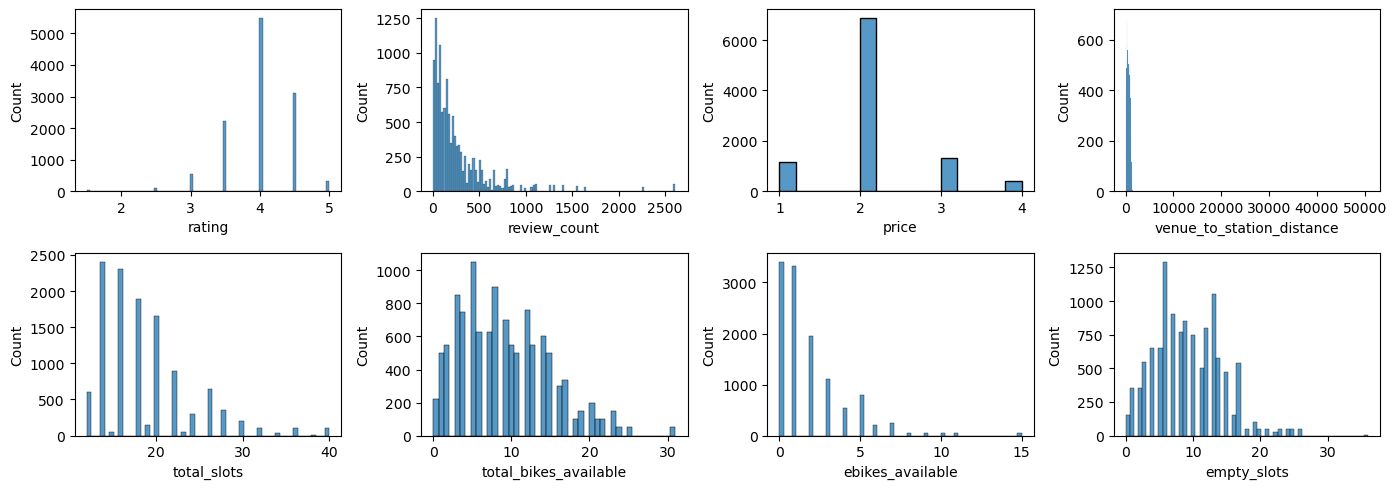

In [395]:
# distribution for each numeric column in dataframe

fig, axes = plt.subplots(2, 4, figsize=(14, 5))
sns.histplot(ax=axes[0,0], data=df, x='rating')
sns.histplot(ax=axes[0,1], data=df, x='review_count')
sns.histplot(ax=axes[0,2], data=df, x='price')
sns.histplot(ax=axes[0,3], data=df, x='venue_to_station_distance')
sns.histplot(ax=axes[1,0], data=df, x='total_slots')
sns.histplot(ax=axes[1,1], data=df, x='total_bikes_available')
sns.histplot(ax=axes[1,2], data=df, x='ebikes_available')
sns.histplot(ax=axes[1,3], data=df, x='empty_slots')

# set axis ranges where necessary
# axes[0,3].set_xlim(0, 1500)
# axes[1,3].set_xlim(0, 30)

fig.tight_layout()

fig.savefig('../images/df_hist.svg')

In [ ]:
# can see that ouliers skey the historgram in review count, venue to station distance, total slots, total bikes available and empty slots

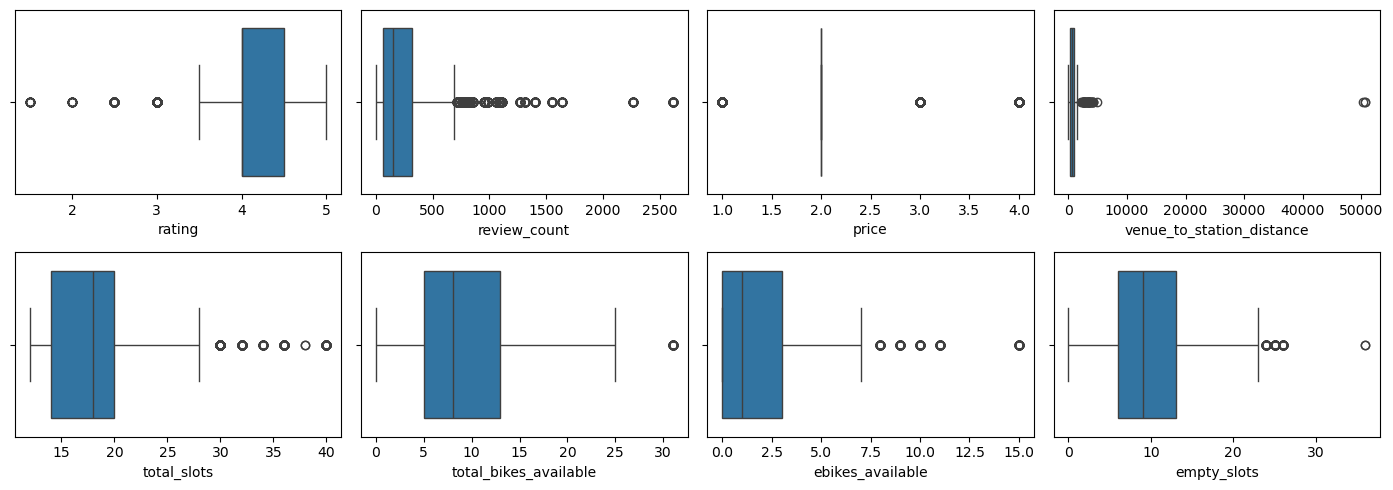

In [435]:
# boxplot for each numeric column in dataframe

fig, axes = plt.subplots(2, 4, figsize=(14, 5))

sns.boxplot(ax=axes[0,0], data=df, x='rating')
sns.boxplot(ax=axes[0,1], data=df, x='review_count')
sns.boxplot(ax=axes[0,2], data=df, x='price')
sns.boxplot(ax=axes[0,3], data=df, x='venue_to_station_distance')
sns.boxplot(ax=axes[1,0], data=df, x='total_slots')
sns.boxplot(ax=axes[1,1], data=df, x='total_bikes_available')
sns.boxplot(ax=axes[1,2], data=df, x='ebikes_available')
sns.boxplot(ax=axes[1,3], data=df, x='empty_slots')

fig.tight_layout()

fig.savefig('../images/df_boxplot.svg')

- given the lack of normal distribution for these variables, will need to identify outliers using IQR method
- can see there are outliers in each variable, will need to identify and remove these

#### Identifying outliers

In [410]:
# Function to return outlier indices based on IQR
def get_outlier_indices(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = column[(column < lower_bound) | (column > upper_bound)].index
    return outlier_indices

# Dictionary to hold outliers for each column
outliers_dict = {}

# List of column names to check for outliers (omit rating and price)
columns_to_check = ['review_count', 'venue_to_station_distance', 'total_slots', 'total_bikes_available', 'ebikes_available', 'empty_slots']

# Loop through columns and apply the function
for column in columns_to_check:
    outliers_dict[column] = get_outlier_indices(df[column])

# Now outliers_dict contains the indices of the outliers for each column
outliers_dict

df_clean = df.copy()

# Remove outliers for each column
for column, indices in outliers_dict.items():
    # find the intersection of the indices to drop with the current dataframe
    indices_to_drop = df_clean.index.intersection(indices)
    
    df_clean = df_clean.drop(indices_to_drop)

# df now has outliers removed based on the specified columns


In [415]:
df_clean.shape, df.shape # 1783 rows removed

((10046, 23), (11829, 23))

In [434]:
# save cleaned dataframe to json file
df_clean.to_json('../data/yelp_citybikes_clean.json', orient='records')

##### Histogram, outliers revomed

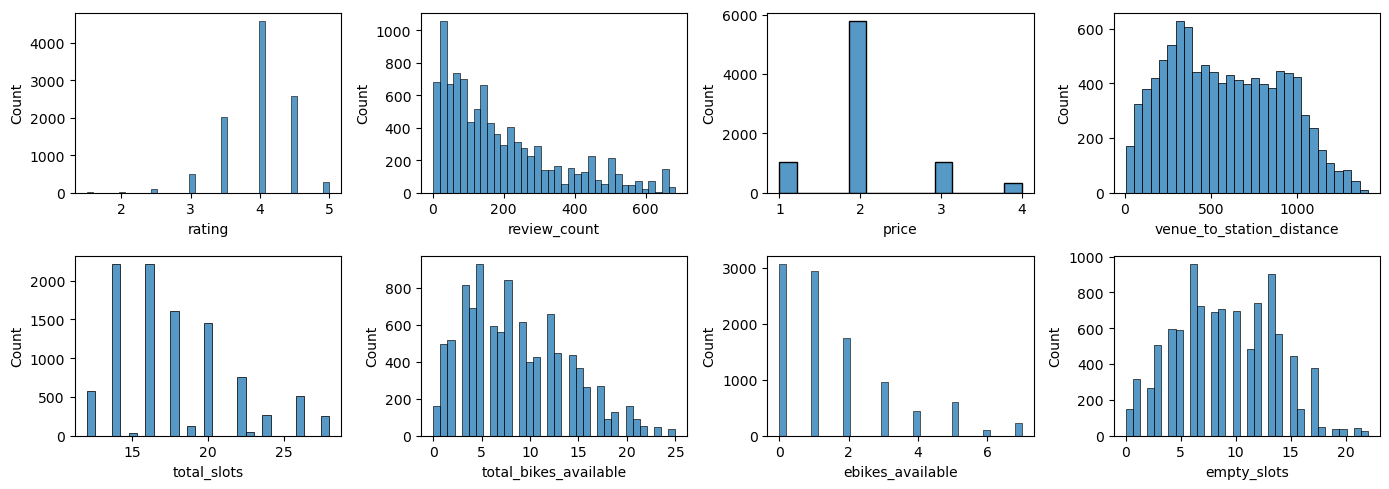

In [436]:
# try visualizing the data with outliers removed
# distribution for each numeric column in dataframe

fig, axes = plt.subplots(2, 4, figsize=(14, 5))
sns.histplot(ax=axes[0,0], data=df_clean, x='rating')
sns.histplot(ax=axes[0,1], data=df_clean, x='review_count')
sns.histplot(ax=axes[0,2], data=df_clean, x='price')
sns.histplot(ax=axes[0,3], data=df_clean, x='venue_to_station_distance')
sns.histplot(ax=axes[1,0], data=df_clean, x='total_slots')
sns.histplot(ax=axes[1,1], data=df_clean, x='total_bikes_available')
sns.histplot(ax=axes[1,2], data=df_clean, x='ebikes_available')
sns.histplot(ax=axes[1,3], data=df_clean, x='empty_slots')

# set axis ranges where necessary
# axes[0,3].set_xlim(0, 1500)
# axes[1,3].set_xlim(0, 30)

fig.tight_layout()

fig.savefig('../images/clean_hist.svg')

##### Boxplot - outliers removed

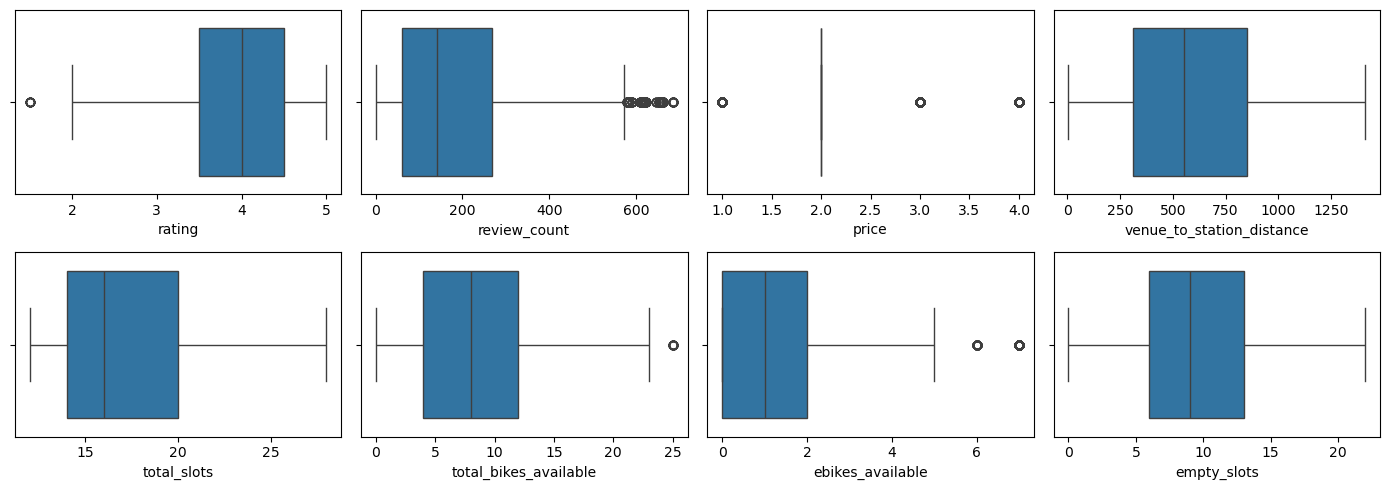

In [438]:
# boxplot for data with outliers removed

fig, axes = plt.subplots(2, 4, figsize=(14, 5))

sns.boxplot(ax=axes[0,0], data=df_clean, x='rating')
sns.boxplot(ax=axes[0,1], data=df_clean, x='review_count')
sns.boxplot(ax=axes[0,2], data=df_clean, x='price')
sns.boxplot(ax=axes[0,3], data=df_clean, x='venue_to_station_distance')
sns.boxplot(ax=axes[1,0], data=df_clean, x='total_slots')
sns.boxplot(ax=axes[1,1], data=df_clean, x='total_bikes_available')
sns.boxplot(ax=axes[1,2], data=df_clean, x='ebikes_available')
sns.boxplot(ax=axes[1,3], data=df_clean, x='empty_slots')

fig.tight_layout()

fig.savefig('../images/clean_boxplot.svg')

#### exploring station data

In [421]:
citybikes_df.describe()

,total_slots,empty_slots,total_bikes_available,normal_bikes_available,ebikes_available,station_info_time,station_latitude,station_longitude
count,248.000000,248.000000,248.000000,248.000000,248.000000,248,248.000000,248.000000
mean,18.810484,9.491935,9.040323,7.125000,1.915323,2023-12-09 13:39:21.000000256,49.271780,-123.119346
min,0.000000,0.000000,0.000000,0.000000,0.000000,2023-12-09 13:39:21,49.238105,-123.252261
25%,15.750000,6.000000,4.750000,2.000000,0.000000,2023-12-09 13:39:21,49.263484,-123.138182
50%,18.000000,9.000000,8.000000,6.000000,1.000000,2023-12-09 13:39:21,49.271063,-123.118073
75%,20.000000,13.000000,13.000000,11.000000,3.000000,2023-12-09 13:39:21,49.280662,-123.099747
max,40.000000,36.000000,31.000000,25.000000,15.000000,2023-12-09 13:39:21,49.302577,-123.056909
std,5.384824,5.317447,5.763067,5.605494,2.268622,NaN,0.011708,0.032818


In [416]:
df_clean.columns

Index(['venue_name', 'rating', 'review_count', 'price',
       'restaurant_categories', 'venue_address', 'venue_to_station_distance',
       'station_name', 'total_slots', 'total_bikes_available', 'empty_slots',
       'normal_bikes_available', 'ebikes_available', 'can_rent', 'can_return',
       'station_info_date', 'station_info_time', 'station_id',
       'station_latitude', 'station_longitude', 'yelp_venue_id',
       'venue_latitude', 'venue_longitude'],
      dtype='object')

##### Station histograms

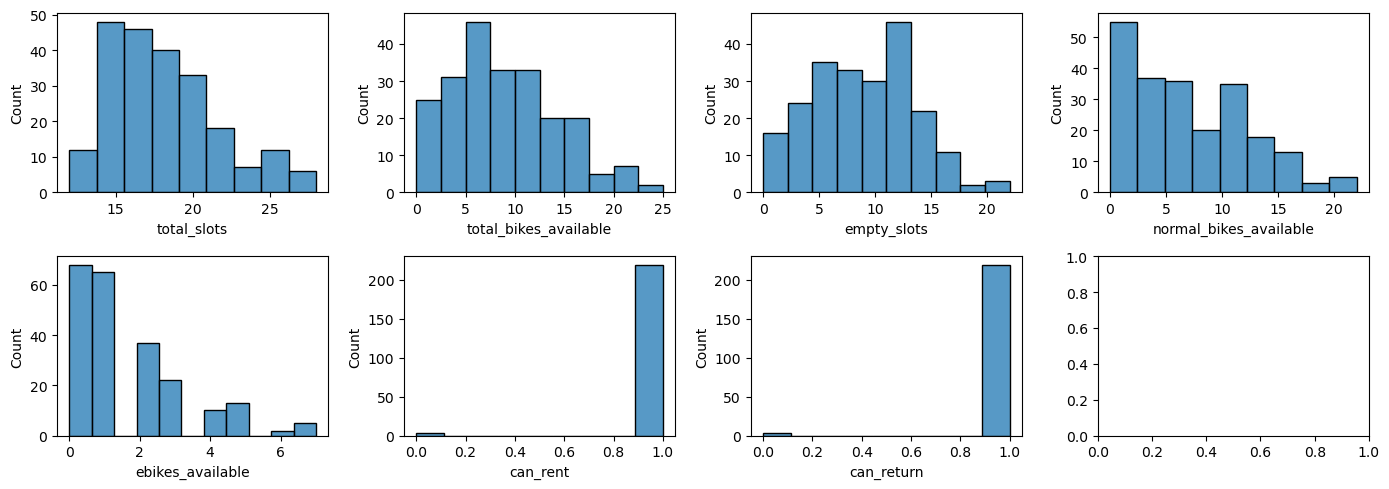

In [423]:
# filter merged dataframe for unique station ids
df_unique_stations = df_clean.drop_duplicates(subset=['station_id'])

fig, axes = plt.subplots(2, 4, figsize=(14, 5))

sns.histplot(ax=axes[0,0], data=df_unique_stations, x='total_slots')
sns.histplot(ax=axes[0,1], data=df_unique_stations, x='total_bikes_available')
sns.histplot(ax=axes[0,2], data=df_unique_stations, x='empty_slots')
sns.histplot(ax=axes[0,3], data=df_unique_stations, x='normal_bikes_available')
sns.histplot(ax=axes[1,0], data=df_unique_stations, x='ebikes_available')
sns.histplot(ax=axes[1,1], data=df_unique_stations, x='can_rent')
sns.histplot(ax=axes[1,2], data=df_unique_stations, x='can_return')

fig.tight_layout()

fig.savefig('../images/station_hist.svg')

##### Station boxplots

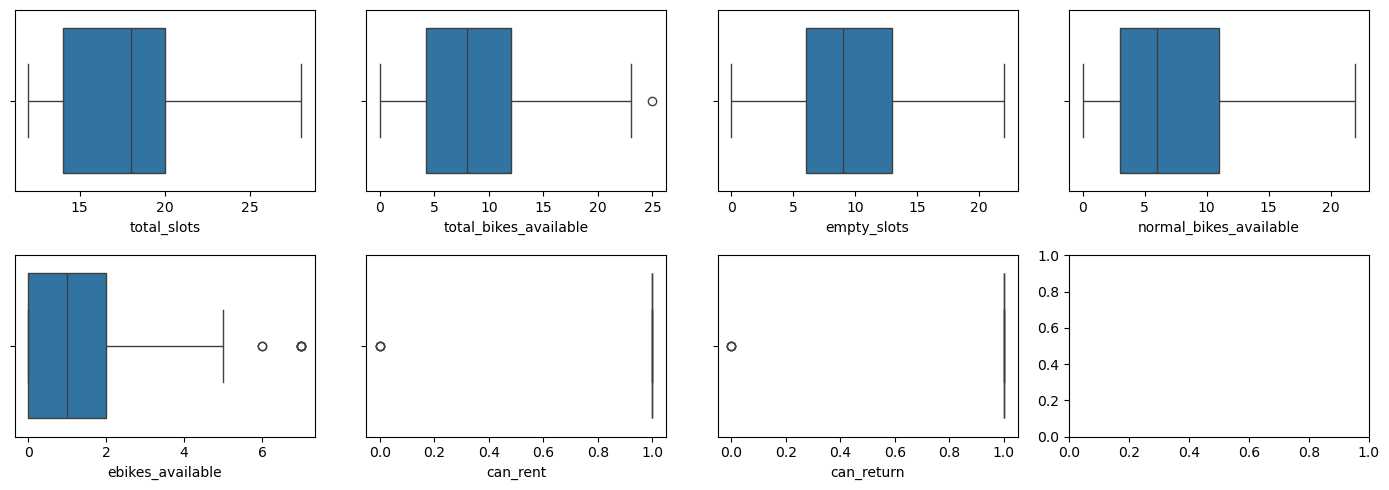

In [422]:
fig, axes = plt.subplots(2, 4, figsize=(14, 5))

sns.boxplot(ax=axes[0,0], data=df_unique_stations, x='total_slots')
sns.boxplot(ax=axes[0,1], data=df_unique_stations, x='total_bikes_available')
sns.boxplot(ax=axes[0,2], data=df_unique_stations, x='empty_slots')
sns.boxplot(ax=axes[0,3], data=df_unique_stations, x='normal_bikes_available')
sns.boxplot(ax=axes[1,0], data=df_unique_stations, x='ebikes_available')
sns.boxplot(ax=axes[1,1], data=df_unique_stations, x='can_rent')
sns.boxplot(ax=axes[1,2], data=df_unique_stations, x='can_return')

fig.tight_layout()

fig.savefig('../images/station_boxplot.svg')

### Misc EDA 

#### Review Count Analysis

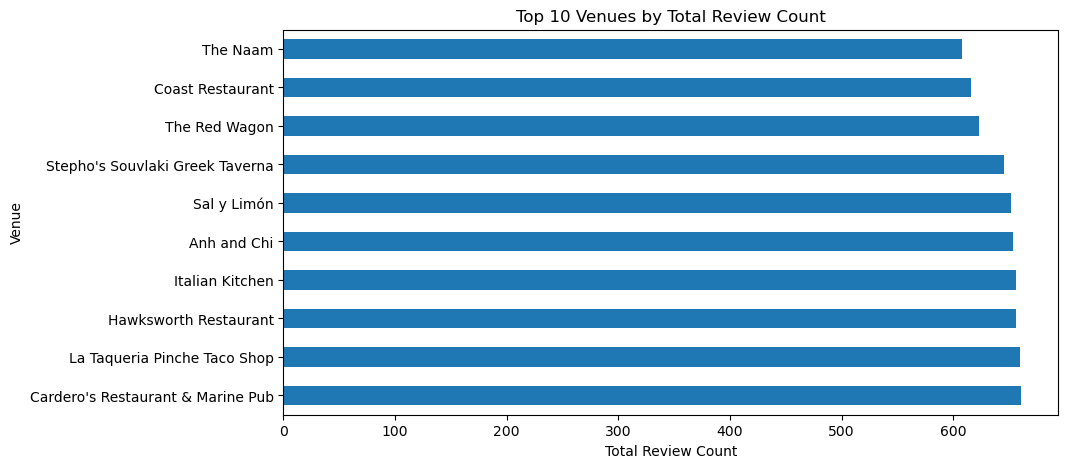

In [439]:
# bar chart of review count for top 10 venues by review count
# Group by 'yelp_venue_id' and calculate the total review count for each venue
review_count_by_venue = df_clean.groupby('venue_name')['review_count'].mean()

# Sort the review counts and take the top 10
top_venues_by_review_count = review_count_by_venue.sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 5))
top_venues_by_review_count.plot(kind='barh')

plt.xlabel('Total Review Count')
plt.ylabel('Venue')
plt.title('Top 10 Venues by Total Review Count')

# Save the plot
fig.savefig('../images/top_reviewed_venues.svg')


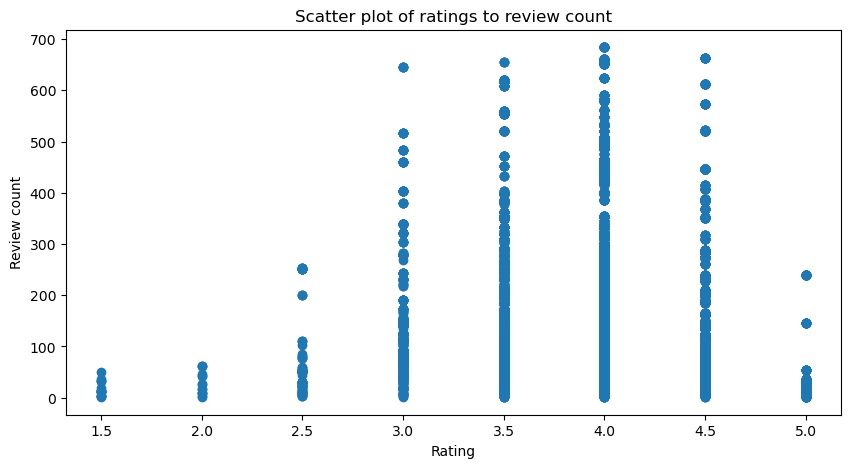

In [440]:
# create scatter plot of ratings to review count
plt.figure(figsize=(10, 5))
plt.scatter(df_clean['rating'], df_clean['review_count'])
plt.xlabel('Rating')
plt.ylabel('Review count')
plt.title('Scatter plot of ratings to review count')

# save scatter plot to file
plt.savefig('../images/ratings_vs_reviewcount.png')

# do more reviews correlate with a higher rating? explore in model notebook

#### Price Level Analysis

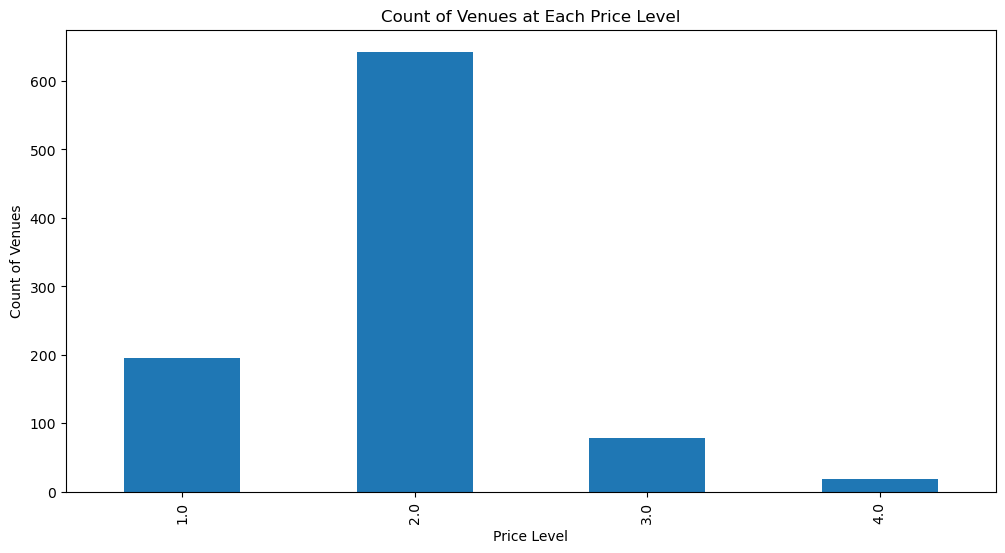

In [441]:
# bar chart of count of venues at each price level
plt.figure(figsize=(12, 6))

df_unique_venues = df_clean.drop_duplicates(subset='yelp_venue_id')

df_unique_venues.groupby('price')['venue_name'].count().plot(kind='bar')

plt.title('Count of Venues at Each Price Level')
plt.xlabel('Price Level')
plt.ylabel('Count of Venues')

# save bar chart to file
plt.savefig('../images/price_level_count.png')

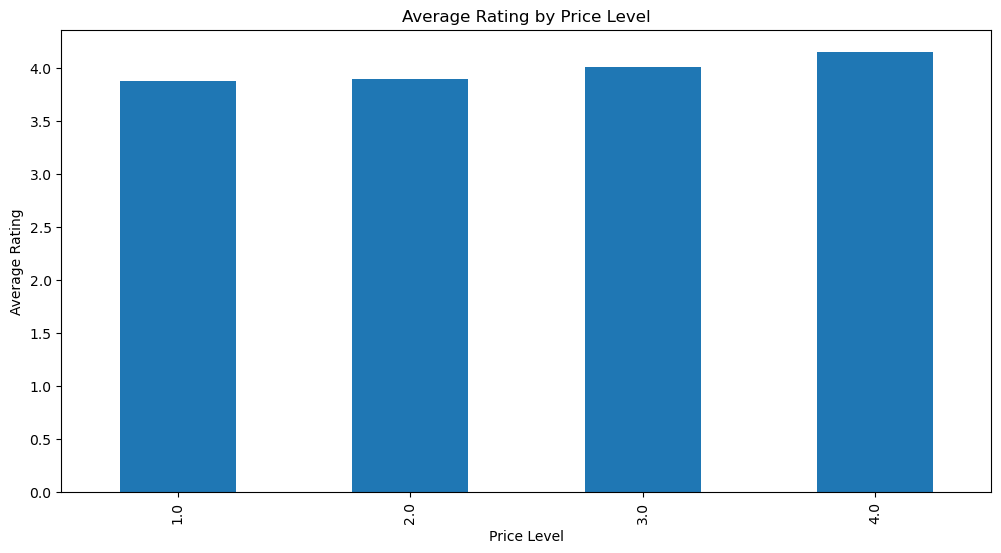

In [442]:
# bar plot of average rating by price level
plt.figure(figsize=(12, 6))
df_clean.groupby('price')['rating'].mean().plot(kind='bar')

plt.title('Average Rating by Price Level')
plt.xlabel('Price Level')
plt.ylabel('Average Rating')

# save bar chart to file
plt.savefig('../images/avg_rating_by_price.png')

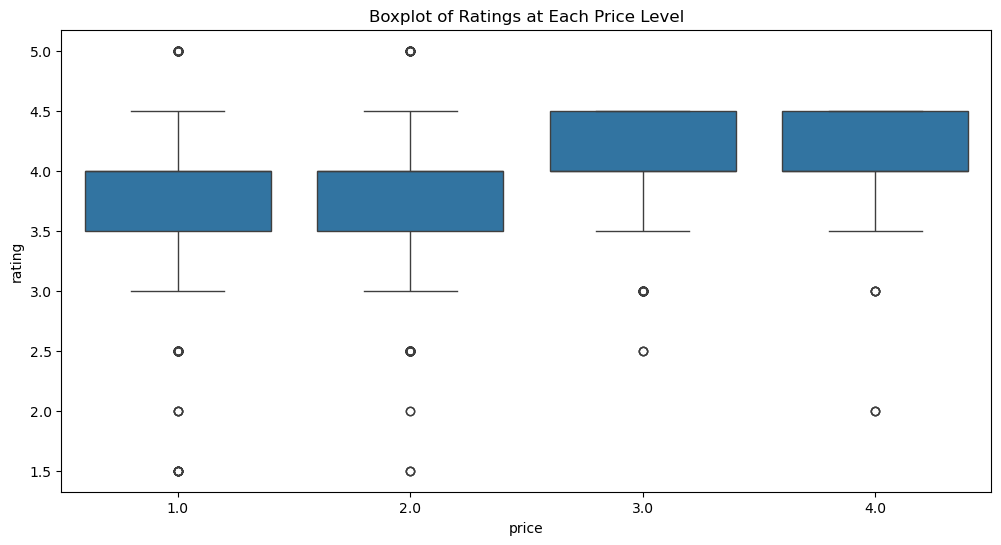

In [443]:
# create boxplot of ratings at each price level
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean, x='price', y='rating')

plt.title('Boxplot of Ratings at Each Price Level')

# save boxplot to file
plt.savefig('../images/ratings_boxplot.png')


#### Category Analysis

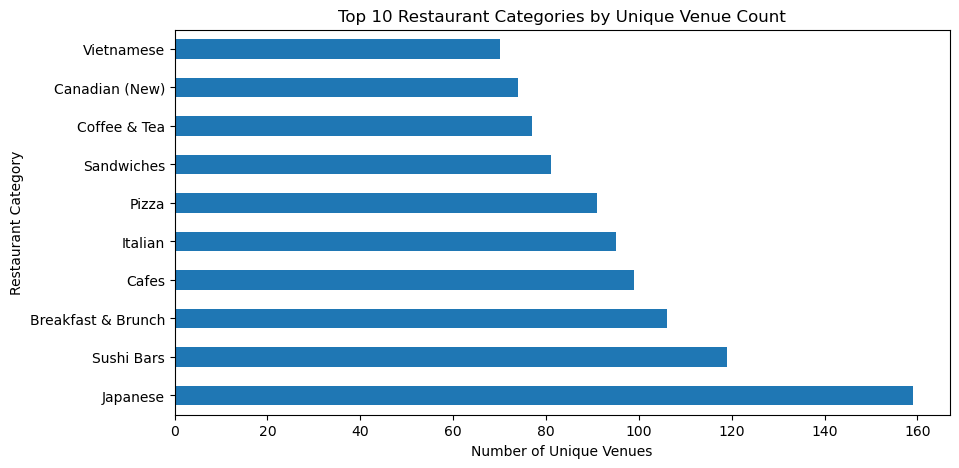

In [445]:
# Explode the 'restaurant_categories' column
df_exploded = df_clean.explode('restaurant_categories')

# Group by 'restaurant_categories' and 'venue_name' to get unique venues in each category
unique_venues_in_category = df_exploded.groupby('restaurant_categories')['yelp_venue_id'].nunique()

# Sort and get the top 10 categories
top_categories = unique_venues_in_category.sort_values(ascending=False).head(10)

# Plotting the top categories
plt.figure(figsize=(10, 5))
top_categories.plot(kind='barh')

plt.xlabel('Number of Unique Venues')
plt.ylabel('Restaurant Category')
plt.title('Top 10 Restaurant Categories by Unique Venue Count')

# Save the plot
plt.savefig('../images/top_categories_bar.png')


# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

#### Set up database connection and define query functions

In [175]:
import sqlite3
from sqlite3 import Error

def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [178]:
connection = create_connection("../data/database.sqlite")

Connection to SQLite DB successful


In [ ]:
# function for executing CREATE, INSERT, UPDATE, DELETE queries
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

Look at the data before and after the join to validate your data.

In [ ]:
# function to execute query and display results as dataframe
def execute_and_display_query(connection, query):
    try:
        cursor = connection.cursor()
        cursor.execute(query)
        results = cursor.fetchall()
        column_names = [description[0] for description in cursor.description]
        df_results = pd.DataFrame(results, columns=column_names)
        display(df_results)
    except Error as e:
        print(f"The error '{e}' occurred")
    finally:
        cursor.close()

#### Create and fill venues table

In [228]:
drop_venues_table = """
DROP TABLE IF EXISTS venues;
"""
create_venues_table = """
CREATE TABLE IF NOT EXISTS venues (
    venue_id TEXT PRIMARY KEY,
    venue_name TEXT NOT NULL,
    venue_address TEXT,
    price INTEGER,
    rating REAL,
    review_count INTEGER,
    venue_latitude REAL NOT NULL,
    venue_longitude REAL NOT NULL
);
"""
execute_query(connection, drop_venues_table)
execute_query(connection, create_venues_table)

Query executed successfully
Query executed successfully


In [229]:
# drop duplicates venues from yelp dataframe
yelp_df_unique = yelp_df.drop_duplicates(subset='yelp_venue_id')

# filter out columns not needed for venues table
yelp_df_unique = yelp_df_unique[['yelp_venue_id', 'venue_name', 'venue_address', 'price', 'rating', 'review_count', 'venue_latitude', 'venue_longitude']]

# rename columns to match venues table
yelp_df_unique = yelp_df_unique.rename(columns={'yelp_venue_id': 'venue_id'})

# convert price column to integer (1-4)
yelp_df_unique['price'] = yelp_df_unique['price'].map({'$': 1, '$$': 2, '$$$': 3, '$$$$': 4})

# load dataframe into venues table
yelp_df_unique.to_sql('venues', connection, if_exists='append', index=False)


1355

In [230]:
# test venues table query
query = 'SELECT * FROM venues'
execute_and_display_query(connection, query)

,venue_id,venue_name,venue_address,price,rating,review_count,venue_latitude,venue_longitude
0,6iOAgzJ0DRZNSKA3FSrrOg,La Taqueria Pinche Taco Shop,2450 Yukon Street,2.0,4.0,684,49.263559,-123.112736
1,nkDZY5xqihF3XtZMzzfqqg,Hokkaido Ramen Santouka,558 W Broadway,2.0,4.0,226,49.263127,-123.116892
2,XAH2HpuUUtu7CUO26pbs4w,Saku,548 W Broadway,2.0,4.5,236,49.263101,-123.116675
3,4118Aq9LbkvUr4s719uUkA,Uma Sushi,450 W 8th Avenue,3.0,4.5,117,49.263805,-123.113729
4,F5wxgIiZE7LYQxgqhI483A,Seaport City Seafood Restaurant,2425 Cambie Street,NaN,4.0,35,49.263921,-123.115152
...,...,...,...,...,...,...,...,...
1350,m6nubWiUgg0gjEOLcKg8uA,Sasamat Seafood Market,4513 10th Ave W,1.0,3.0,5,49.263988,-123.209566
1351,luaK3Xrqr42QMU6F-LLm9Q,Hime Sushi,4490 10th Avenue W,NaN,3.5,2,49.263686,-123.208734
1352,HDw5Dqqwbcym7123exU1Sw,Danoo Cafe,4462 10th Avenue W,NaN,3.5,8,49.263691,-123.208146
1353,iPujVXzNJ-NYjhylcjSFxw,Domino's Pizza,4426 10th Avenue W,NaN,5.0,1,49.263665,-123.206821


#### Create and fill stations table

In [263]:
drop_stations_table = """
DROP TABLE IF EXISTS stations;
"""
create_stations_table = """
CREATE TABLE IF NOT EXISTS stations (
    station_id TEXT PRIMARY KEY,
    station_name TEXT NOT NULL,
    total_slots INTEGER,
    empty_slots INTEGER,
    total_bikes_available INTEGER,
    normal_bikes_available INTEGER,
    ebikes_available INTEGER,
    can_rent BOOLEAN,
    can_return BOOLEAN,
    station_latitude REAL NOT NULL,
    station_longitude REAL NOT NULL
);
"""
execute_query(connection, drop_stations_table)
execute_query(connection, create_stations_table)

Query executed successfully
Query executed successfully


In [264]:
# prep citybikes dataframe for loading into stations table

# filter out columns not needed for stations table
stations_df = citybikes_df[['station_id', 'station_name', 'total_slots', 'empty_slots', 'total_bikes_available', 'normal_bikes_available', 'ebikes_available', 'can_rent', 'can_return', 'station_latitude', 'station_longitude']]

# load dataframe into stations table
stations_df.to_sql('stations', connection, if_exists='append', index=False)

248

In [265]:
# test stations table query
query = 'SELECT * FROM stations'
execute_and_display_query(connection, query)

,station_id,station_name,total_slots,empty_slots,total_bikes_available,normal_bikes_available,ebikes_available,can_rent,can_return,station_latitude,station_longitude
0,7a19c49f486d7c0c02b3685d7b240448,10th & Cambie,36,13,22,17,5,1,1,49.262487,-123.114397
1,32603a87cfca71d0f7dfa3513bad69d5,Yaletown-Roundhouse Station,16,11,5,4,1,1,1,49.274566,-123.121817
2,6d42fa40360f9a6b2bf641c7b8bb2862,Dunsmuir & Beatty,26,1,25,21,4,1,1,49.279764,-123.110154
3,66f873d641d448bd1572ab086665a458,12th & Yukon (City Hall),16,13,2,1,1,1,1,49.260599,-123.113504
4,485d4d24c803cfde829ab89699fed833,8th & Ash,16,9,7,2,5,1,1,49.264215,-123.117772
...,...,...,...,...,...,...,...,...,...,...,...
243,db1e56a71a3279f51301d732ee5a055b,IK Barber Learning Centre,20,16,4,1,3,1,1,49.267561,-123.252261
244,5726de7c5646b82f7aaeafba50aee03e,War Memorial Gym,28,17,11,1,10,1,1,49.266579,-123.248549
245,cde61c70e5556ee2fe3ceb9d958b6482,Pharmaceutical Sciences,24,15,9,0,9,1,1,49.262620,-123.243100
246,852212d6d52b5f00544fad01d21c7db2,Georgia & Main,0,0,0,0,0,0,0,49.278529,-123.100017


#### Create and fill venue_station_distance table

In [ ]:
drop_vsd_table = """
DROP TABLE IF EXISTS venues;
"""

create_venue_station_distance_table = """
CREATE TABLE IF NOT EXISTS venue_station_distance (
    venue_id INTEGER,
    station_id INTEGER,
    distance REAL NOT NULL,
    FOREIGN KEY (venue_id) REFERENCES venues (venue_id),
    FOREIGN KEY (station_id) REFERENCES stations (station_id),
    PRIMARY KEY (venue_id, station_id)
);
"""
execute_query(connection, drop_vsd_table)
execute_query(connection, create_venues_table)

In [196]:
# venue_station_distance table: prepare data and insert

venue_station_distance_df = df[['yelp_venue_id', 'station_id', 'venue_to_station_distance']]
# rename columns to match database table
venue_station_distance_df.columns = ['venue_id', 'station_id', 'distance']
# drop duplicates
venue_station_distance_df = venue_station_distance_df.drop_duplicates()

# load dataframe into database table
venue_station_distance_df.to_sql('venue_station_distance', connection, if_exists='append', index=False)

In [ ]:
# test query
query = 'SELECT * FROM venue_station_distance WHERE distance < 100'
execute_and_display_query(connection, query)

,venue_id,station_id,distance
0,31ag-M_QiaycGQrvAi169w,7a19c49f486d7c0c02b3685d7b240448,69.661406
1,1AA4EjIIXywxOSnbyZ9vLA,7a19c49f486d7c0c02b3685d7b240448,98.307524
2,NdEPf2Ls5Ql3_nkwjqKvXA,32603a87cfca71d0f7dfa3513bad69d5,54.990917
3,mkqiEUO9KZbYtFPaDGxT0w,32603a87cfca71d0f7dfa3513bad69d5,32.136642
4,zSVlSPVRWk2I9u28cE8brw,32603a87cfca71d0f7dfa3513bad69d5,99.754418
...,...,...,...
535,jI_ZG0HkmjDwEIJAimXFIw,34fd37d12eb989b49518ef53941ee3ff,83.739606
536,m6nubWiUgg0gjEOLcKg8uA,34fd37d12eb989b49518ef53941ee3ff,21.521761
537,luaK3Xrqr42QMU6F-LLm9Q,34fd37d12eb989b49518ef53941ee3ff,48.977551
538,HDw5Dqqwbcym7123exU1Sw,34fd37d12eb989b49518ef53941ee3ff,81.173096


#### Create and fill categories table

In [266]:
drop_categories_table = """
DROP TABLE IF EXISTS categories;
"""
create_categories_table = """
CREATE TABLE IF NOT EXISTS categories (
    category_id TEXT PRIMARY KEY,
    category_name TEXT NOT NULL
);
"""
execute_query(connection, drop_categories_table)
execute_query(connection, create_categories_table)

Query executed successfully
Query executed successfully


In [267]:
# prep cateogries dataframe for loading into categories table

unique_categories = set(category for sublist in yelp_df['restaurant_categories'] for category in sublist)
categories_df = pd.DataFrame(list(unique_categories), columns=['category_name'])
# put into alphabetical order
categories_df = categories_df.sort_values(by=['category_name'])
# add category_id column as primary key
categories_df['category_id'] = range(1, len(categories_df) + 1)
# convert category_id to string
categories_df['category_id'] = categories_df['category_id'].astype(str)

# pad index with leading zeros
categories_df['category_id'] = categories_df['category_id'].apply(lambda x: x.zfill(3))

# load dataframe into categories table
categories_df.to_sql('categories', connection, if_exists='append', index=False)

161

In [268]:
# test stations table query
query = 'SELECT * FROM categories'
execute_and_display_query(connection, query)

,category_id,category_name
0,001,Acai Bowls
1,002,Afghan
2,003,African
3,004,American
4,005,Arabic
...,...,...
156,157,Venues & Event Spaces
157,158,Vietnamese
158,159,Waffles
159,160,Whiskey Bars


#### Create and fill venue_categories table

In [297]:
drop_venue_categories_table = """
DROP TABLE IF EXISTS venue_categories;
"""
create_venue_categories_table = """
CREATE TABLE IF NOT EXISTS venue_categories (
    venue_id TEXT,
    category_id TEXT,
    FOREIGN KEY (venue_id) REFERENCES venues (venue_id),
    FOREIGN KEY (category_id) REFERENCES categories (category_id),
    PRIMARY KEY (venue_id, category_id)
);
"""
execute_query(connection, drop_venue_categories_table)
execute_query(connection, create_venue_categories_table)

Query executed successfully
Query executed successfully


In [298]:
# Create a DataFrame for venue-category relationships

# create dataframe of unique venues and categories
unique_venues = yelp_df[['yelp_venue_id', 'restaurant_categories']].drop_duplicates(subset='yelp_venue_id')

# explode restaurant_categories column so each row has one category
unique_venues = unique_venues.explode('restaurant_categories')
# rename columns to match database table
unique_venues.columns = ['venue_id', 'category_name']
# merge with categories dataframe to get category_id
unique_venues = unique_venues.merge(categories_df, on='category_name', how='left')
# drop category_name column (normalization)
unique_venues.drop(['category_name'], axis=1, inplace=True)

# load dataframe into database table
unique_venues.to_sql('venue_categories', connection, if_exists='append', index=False)

2743

In [475]:
# test stations table query
query = 'SELECT * FROM venue_categories'
execute_and_display_query(connection, query)

,venue_id,category_id
0,6iOAgzJ0DRZNSKA3FSrrOg,101
1,nkDZY5xqihF3XtZMzzfqqg,107
2,nkDZY5xqihF3XtZMzzfqqg,126
3,nkDZY5xqihF3XtZMzzfqqg,135
4,XAH2HpuUUtu7CUO26pbs4w,087
...,...,...
2738,iPujVXzNJ-NYjhylcjSFxw,035
2739,iPujVXzNJ-NYjhylcjSFxw,129
2740,8GiUobn2TsWF-3oXC9s_DA,117
2741,8GiUobn2TsWF-3oXC9s_DA,035


### Database validation

In [465]:
# check primary keys are unique

# venue categories (composite primary key: venue_id, category_id)
query = 'SELECT COUNT(*) FROM venue_categories'
execute_and_display_query(connection, query)

query = 'SELECT DISTINCT COUNT(*) FROM venue_categories'
execute_and_display_query(connection, query)


# venue station distance (composite primary key: venue_id, station_id)
query = 'SELECT COUNT(*) FROM venue_station_distance'
execute_and_display_query(connection, query)

query = 'SELECT DISTINCT COUNT(*) FROM venue_station_distance'
execute_and_display_query(connection, query)


# categories (primary key: category_id)
query = 'SELECT COUNT(*) FROM categories'
execute_and_display_query(connection, query)

query = 'SELECT DISTINCT COUNT(*) FROM categories'
execute_and_display_query(connection, query)


# stations (primary key: station_id)
query = 'SELECT COUNT(*) FROM stations'
execute_and_display_query(connection, query)

query = 'SELECT DISTINCT COUNT(*) FROM stations'
execute_and_display_query(connection, query)


# venues (primary key: venue_id)
query = 'SELECT COUNT(*) FROM venues'
execute_and_display_query(connection, query)

query = 'SELECT DISTINCT COUNT(*) FROM venues'
execute_and_display_query(connection, query)

,COUNT(*)
0,2743


,COUNT(*)
0,2743


,COUNT(*)
0,11829


,COUNT(*)
0,11829


,COUNT(*)
0,161


,COUNT(*)
0,161


,COUNT(*)
0,248


,COUNT(*)
0,248


,COUNT(*)
0,1355


,COUNT(*)
0,1355


In [471]:
# check foreign keys are valid

# venue_categories (venue_id FK)
query = 'SELECT COUNT(*) FROM venue_categories WHERE venue_id NOT IN (SELECT venue_id FROM venues)'
execute_and_display_query(connection, query)

# venue_categories (category_id FK)
query = 'SELECT COUNT(*) FROM venue_categories WHERE category_id NOT IN (SELECT category_id FROM categories)'
execute_and_display_query(connection, query)


# venue_station_distance (venue_id FK)
query = 'SELECT COUNT(*) FROM venue_station_distance WHERE venue_id NOT IN (SELECT venue_id FROM venues)'
execute_and_display_query(connection, query)

# venue_station_distance (station_id FK)
query = 'SELECT COUNT(*) FROM venue_station_distance WHERE station_id NOT IN (SELECT station_id FROM stations)'
execute_and_display_query(connection, query)

,COUNT(*)
0,0


,COUNT(*)
0,0


,COUNT(*)
0,0


,COUNT(*)
0,0
